# Logistic smooth regression fit

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

In [2]:
%cd /g/data/w42/dr6273/work/project_demo

/g/data/w42/dr6273/work/project_demo


In [71]:
%matplotlib inline

In [3]:
FONTSIZE = 10
plt_params = {
    'font.size': FONTSIZE,
    'legend.fontsize' : FONTSIZE - 1,
}

### Load NSW demand data
Data originally obtained from AEMO vie NEMOSIS python package.

In [4]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_20091201-20210130.csv"
)

In [5]:
demand.index = pd.date_range("2009-12-01", "2021-01-30")

In [90]:
q = demand["NSW"]

In [91]:
q = q.loc[slice("2010", "2020")]

In [92]:
q

2010-01-01    187807.390
2010-01-02    189870.310
2010-01-03    182687.900
2010-01-04    200653.775
2010-01-05    214943.745
                 ...    
2020-12-27    163156.770
2020-12-28    162005.010
2020-12-29    164337.420
2020-12-30    164464.285
2020-12-31    160221.400
Freq: D, Name: NSW, Length: 4018, dtype: float64

### Sydney temperature

In [93]:
def preprocess(ds):
    """
    Select grid cell.
    """
    return ds.sel(longitude=151.2, latitude=-33.86, method="nearest")

In [94]:
da_list = []
for year in range(2010, 2021):
    da = xr.open_mfdataset(
        "/g/data/rt52/era5/single-levels/reanalysis/2t/"+str(year)+"/*.nc",
        preprocess=preprocess
    )["t2m"]
    da_list.append(da.resample(time="1D").mean())

In [95]:
t = xr.concat(da_list, dim="time").compute()

In [96]:
t = t - 273.15

### Fit model

In [97]:
def lstr(x, a1, a2, b1, b2, z, c):
    """
    Logistic smooth transition equation
    """
    F = 1 / (1 + np.exp(-z * (x - c)))
    term1 = (a1 + b1 * x) * (1 - F)
    term2 = (a2 + b2 * x) * F
    return term1 + term2

In [98]:
def fit_model(model, x, y, inits):
    """
    Fit logistic smooth transition regression to data.
    """
    x = x.values
    y = y.values
    
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    params, _ = curve_fit(model, x, y, p0=inits, maxfev=25000)
    return params

In [99]:
# Initial parameter coefficients
inits = [-6e6, -4e3, 2e3, 2e1, 0.2, 0]

In [100]:
# Fit the model
a1, a2, b1, b2, z, c = fit_model(lstr, t, q/1000, inits=inits)

In [104]:
# Get predictions
x_line = np.arange(11, 29, 1)
y_line = lstr(x_line, a1, a2, b1, b2, z, c)

### Plot

In [139]:
def plot_fit(ax, x_scatter, y_scatter, x_fit, y_fit, title):
    """
    Scatter plot of demand vs temperature with model fit line
    """
    ax.scatter(x_scatter, y_scatter, alpha=0.1, s=10)
    ax.plot(x_fit, y_fit, c="k")
    ax.set_xlabel(r"Sydney temperature [$^{\circ}$C]")
    ax.set_ylabel(r"Demand [GWh day$^{-1}$]")
    ax.set_title(title)

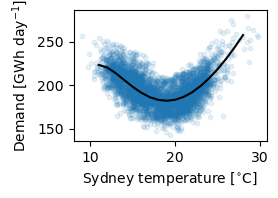

In [143]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(figsize=(2.5, 1.7))
    plot_fit(ax, t, q/1000, x_line, y_line, "")
    plt.savefig("./figures/demand.pdf", format="pdf", dpi=400, bbox_inches="tight")